### Integration with a quantum circuit and automatic differentiation

In this tutorial we exploit the automatic differentiation of our quantum model with respect to the input data to perform the calculation of integrals.

---

The core idea is inspired by [J. M. Cruz-Martinez et al.](https://iopscience.iop.org/article/10.1088/2058-9565/ad5866) and consists in training the derivative of a quantum circuit output w.r.t. input data to approximate the integrand function of a target integration problem. Once the derivative of the circuit is trained to approximate the integrand, then the original circuit can be used to compute any definite integral value by applying the fundamental theorem of the integral calculus.

$$ I = \int g(x) dx $$

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn as nn

from qibo import Circuit, gates, hamiltonians, set_backend, construct_backend

from qiboml.models.encoding import PhaseEncoding
from qiboml.models.decoding import Expectation
from qiboml.interfaces.pytorch import QuantumModel
from qiboml.operations.differentiation import PSR, Jax

2025-04-11 17:40:56.898983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744386056.917974   38242 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744386056.923671   38242 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744386056.937957   38242 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744386056.937976   38242 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744386056.937980   38242 computation_placer.cc:177] computation placer alr

We consider a dummy 1-dimensional target here.

In [2]:
def integrand_function(x):
    return 1/2*x + torch.sin(3 * x)

def integral_function(x):
    return x ** 2 / 4 - torch.cos(3 * x)/3 

def definite_integral(xa, xb):
    return integral_function(xb) - integral_function(xa)

npoints = 30
nqubits = 1
nlayers = 5

In [3]:
x = torch.linspace(0, 2, npoints)
g = integrand_function(x)
I = integral_function(x)

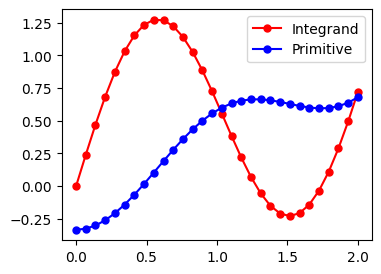

In [4]:
plt.figure(figsize=(4, 3))
plt.plot(x, g, label="Integrand", c="red", marker=".", markersize=10)
plt.plot(x, I, label="Primitive", c="blue", marker=".", markersize=10)
plt.legend()
plt.show()

Then we use a data reuploading strategy to upload the data into a quantum circuit, alternating data-encoding gates with trainable blocks of gates in our circuit. 

[Qibo 0.2.17|INFO|2025-04-11 17:41:02]: Using qiboml (pytorch) backend on cpu


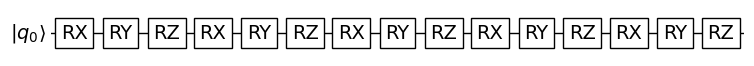

In [5]:
x_train = torch.linspace(0., 2., npoints, dtype=torch.float32).unsqueeze(1)
x_train = x_train.clone().detach().requires_grad_(True)
y_train = integrand_function(x_train)

set_backend("qiboml", platform="pytorch")


# Encoding layer
encoding_circ = PhaseEncoding(
    nqubits=nqubits, 
    encoding_gate=gates.RX
)

# Trainable layer
def trainable_circuit(entanglement=True):
    trainable_circ  = Circuit(nqubits)
    for q in range(nqubits):
        trainable_circ.add(gates.RY(q=q, theta=np.random.randn()))
        trainable_circ.add(gates.RZ(q=q, theta=np.random.randn()))
    if nqubits > 1 and entanglement:
        [trainable_circ.add(gates.CNOT(q%nqubits, (q+1)%nqubits) for q in range(nqubits))]
    return trainable_circ

# Decoding layer
decoding_circ = Expectation(
    nqubits=nqubits, 
    backend=construct_backend("qiboml", platform="pytorch")
    # backend=construct_backend("numpy")
)

circuit_structure = []
for _ in range(nlayers):
    circuit_structure.extend(
        [encoding_circ, trainable_circuit(entanglement=True)]
    )

# The whole model
model = QuantumModel(
    circuit_structure=circuit_structure,
    decoding=decoding_circ,
    # differentiation=Jax()
)

model.draw()

optimizer = optim.Adam(model.parameters(), lr=0.1, betas=(0.9, 0.99))
criterion = nn.MSELoss()

def prediction(model, x_i):
    y_pred = model(x_i)
    dydx = torch.autograd.grad(
        outputs=y_pred,
        inputs=x_i,
        grad_outputs=torch.ones_like(y_pred),
        create_graph=True,
        retain_graph=True,
        allow_unused=True,
    )[0]
    return dydx

def loss_function(model, x, target):
    losses = []
    # Process each sample separately.
    for x_i, target_i in zip(x, target):
        # x_i and target_i are single samples (with proper shape)
        dydx = prediction(model, x_i)
        losses.append(criterion(dydx, target_i.unsqueeze(0)))
    return torch.stack(losses).mean()


We have a look to a first random guess of our model.

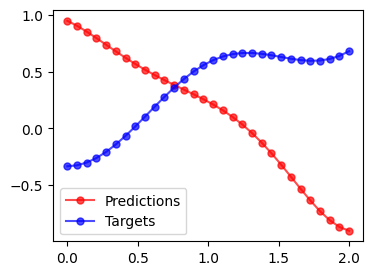

In [6]:
y_pred = torch.stack([model(x) for x in x_train])
y_pred = y_pred.squeeze(-1)

plt.figure(figsize=(4, 4 * 6 / 8), dpi=100)
plt.plot(
    x_train.detach().numpy(), 
    y_pred.detach().numpy(), 
    marker=".",
    markersize=10,
    color="red", 
    label="Predictions",
    alpha=0.7
)
plt.plot(
    x, 
    I,
    marker=".",
    markersize=10,
    color="blue", 
    label="Targets",
    alpha=0.7
)
plt.legend()
plt.show()

### Model training

In [7]:
for epoch in range(200):
    optimizer.zero_grad()
    
    # Compute loss using the wrapped loss function
    loss = loss_function(model, x_train, y_train)
    
    loss.backward(retain_graph=True)
    optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")

/home/matteo/dev/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: Loss = 2.1013600826263428
Epoch 5: Loss = 0.5011771321296692
Epoch 10: Loss = 0.12502336502075195
Epoch 15: Loss = 0.040936172008514404
Epoch 20: Loss = 0.08370252698659897
Epoch 25: Loss = 0.05856318771839142
Epoch 30: Loss = 0.03186345100402832
Epoch 35: Loss = 0.033597372472286224
Epoch 40: Loss = 0.019424816593527794
Epoch 45: Loss = 0.02385425753891468
Epoch 50: Loss = 0.017825031653046608
Epoch 55: Loss = 0.016136223450303078
Epoch 60: Loss = 0.01544010080397129
Epoch 65: Loss = 0.014807898551225662
Epoch 70: Loss = 0.014280816540122032
Epoch 75: Loss = 0.013451507315039635
Epoch 80: Loss = 0.01315404288470745
Epoch 85: Loss = 0.012599840760231018
Epoch 90: Loss = 0.012149742804467678
Epoch 95: Loss = 0.011670238338410854
Epoch 100: Loss = 0.011231168173253536
Epoch 105: Loss = 0.010780616663396358
Epoch 110: Loss = 0.01035469863563776
Epoch 115: Loss = 0.00993108656257391
Epoch 120: Loss = 0.009514187462627888
Epoch 125: Loss = 0.009111065417528152
Epoch 130: Loss = 0.0

### Predictions

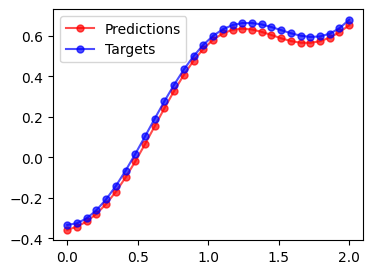

In [8]:
y_pred = torch.stack([model(x) for x in x_train])
y_pred = y_pred.squeeze(-1)

plt.figure(figsize=(4, 4 * 6 / 8), dpi=100)
plt.plot(
    x_train.detach().numpy(), 
    y_pred.detach().numpy(), 
    marker=".",
    
    markersize=10,
    color="red", 
    label="Predictions",
    alpha=0.7
)
plt.plot(
    x, 
    I,
    marker=".",
    markersize=10,
    color="blue", 
    label="Targets",
    alpha=0.7
)
plt.legend()
plt.show()

As expected, the solution is good but for a constant value. This is not a problem, because we need to use the model to compute definite integral values as follows:

In [9]:
x_a = torch.tensor(0.01)
x_b = torch.tensor(1.2)

print(
    "Def integral exact:", 
    definite_integral(x_a, x_b)
)
print(
    "Approx integral:", 
     (model(x_b) - model(x_a)).squeeze().detach().numpy()
)

Def integral exact: tensor(0.9921)
Approx integral: 0.9898888889322334
